In [51]:
# Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import set_config
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
# Load the dataset using pandas
file_path = "C:/Users/sakik/OneDrive/Documents/Personal Documents/Studies IU/5th Quarter/Model Engineering/data/raw/PSP_Jan_Feb_2019.xlsx"
df = pd.read_excel(file_path)

# Exploring the dataset
print("First 5 rows of the dataset:")
print(df.head())

# Summary statistics for numerical columns
print("\nBasic statistics:")
print(df.describe())

# Checking for missing values in the dataset
print("\nMissing values in each column:")
print(df.isnull().sum())

First 5 rows of the dataset:
   Unnamed: 0                tmsp  country  ...         PSP  3D_secured    card
0           0 2019-01-01 00:01:11  Germany  ...     UK_Card           0    Visa
1           1 2019-01-01 00:01:17  Germany  ...     UK_Card           0    Visa
2           2 2019-01-01 00:02:49  Germany  ...     UK_Card           1  Diners
3           3 2019-01-01 00:03:13  Germany  ...     UK_Card           1  Diners
4           4 2019-01-01 00:04:33  Austria  ...  Simplecard           0  Diners

[5 rows x 8 columns]

Basic statistics:
         Unnamed: 0                           tmsp  ...       success    3D_secured
count  50410.000000                          50410  ...  50410.000000  50410.000000
mean   25204.500000  2019-01-29 16:28:52.923269120  ...      0.202896      0.238266
min        0.000000            2019-01-01 00:01:11  ...      0.000000      0.000000
25%    12602.250000  2019-01-14 12:00:36.249999872  ...      0.000000      0.000000
50%    25204.500000     2019-0


PSP success rates and transaction statistics:
          PSP  success_rate  avg_amount  transaction_count
0    Goldcard      0.406172  203.395574               3208
1   Moneycard      0.218754  201.892853               8297
2  Simplecard      0.158123  201.356661              12446
3     UK_Card      0.194338  202.920934              26459


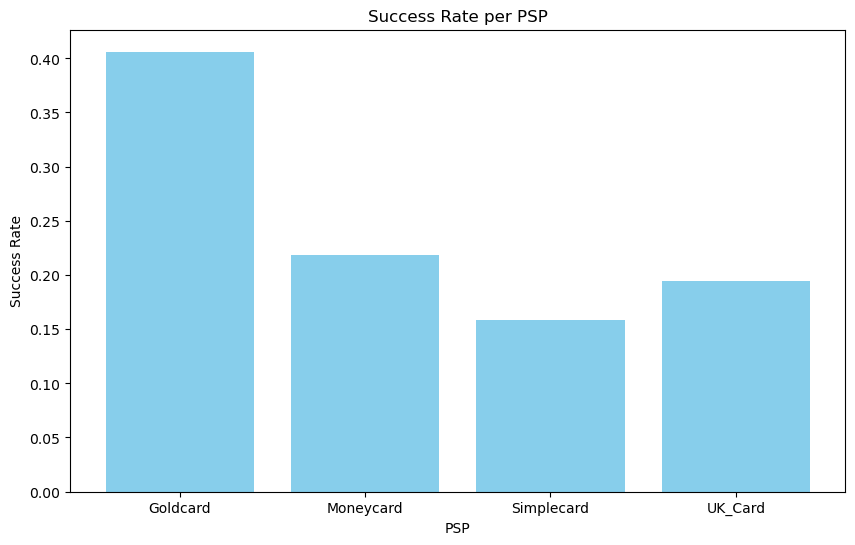

In [43]:
# Grouping by PSP to get success rates and average transaction amount
psp_stats = df.groupby('PSP').agg(
    success_rate=('success', 'mean'), 
    avg_amount=('amount', 'mean'), 
    transaction_count=('success', 'size')
).reset_index()

print("\nPSP success rates and transaction statistics:")
print(psp_stats)

os.makedirs('reports', exist_ok=True)

# Bar plot to show the success rates for each PSP
plt.figure(figsize=(10,6))
plt.bar(psp_stats['PSP'], psp_stats['success_rate'], color='skyblue')
plt.title('Success Rate per PSP')
plt.xlabel('PSP')
plt.ylabel('Success Rate')
plt.savefig('reports/success_rate_per_psp.png')
plt.show()


In [5]:
# Sorting the data by timestamp
df = df.sort_values(by='tmsp')

# Grouping multiple payment attempts within 1 minute
df['attempt_group'] = ((df['tmsp'].diff().dt.total_seconds() < 60) &
                       (df['amount'] == df['amount'].shift(1)) &
                       (df['country'] == df['country'].shift(1))).cumsum()

print("\nSample of grouped transactions:")
print(df[['tmsp', 'country', 'amount', 'attempt_group']].head(10))



Sample of grouped transactions:
                 tmsp      country  amount  attempt_group
0 2019-01-01 00:01:11      Germany      89              0
1 2019-01-01 00:01:17      Germany      89              1
2 2019-01-01 00:02:49      Germany     238              1
3 2019-01-01 00:03:13      Germany     238              2
4 2019-01-01 00:04:33      Austria     124              2
5 2019-01-01 00:06:41  Switzerland     282              2
6 2019-01-01 00:07:19  Switzerland     282              3
7 2019-01-01 00:08:46      Germany     117              3
8 2019-01-01 00:09:56  Switzerland     174              3
9 2019-01-01 00:10:49  Switzerland     174              4


In [6]:
# Extracting useful information from the timestamp column
df['hour'] = df['tmsp'].dt.hour
df['day_of_week'] = df['tmsp'].dt.dayofweek

# Encoding categorical variables
# Encode the PSP and card columns for model building
label_encoder = LabelEncoder()
df['PSP_encoded'] = label_encoder.fit_transform(df['PSP'])
df['card_encoded'] = label_encoder.fit_transform(df['card'])


In [7]:
# Ensure processed data folder exists
import os
os.makedirs('data/processed', exist_ok=True)

# Save the processed data as CSV
df.to_csv('data/processed/processed_transactions.csv', index=False)


In [8]:
# Selecting the features and target variable
X = df[['amount', 'PSP_encoded', '3D_secured', 'hour', 'day_of_week']]
y = df['success']

# Splitting the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [56]:
# Cross-validation for Logistic Regression
cv_scores_log_reg = cross_val_score(LogisticRegression(), X, y, cv=5)
print(f"Logistic Regression Cross-Validation Accuracy: {cv_scores_log_reg.mean() * 100:.2f}%")

# Logistic Regression model to predict transaction success
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Making predictions and evaluating the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nLogistic Regression Accuracy: {accuracy * 100:.2f}%")

# Saving the Logistic Regression evaluation results
with open('reports/logistic_regression_results.txt', 'w') as f:
    f.write(f"Logistic Regression Cross-Validation Accuracy: {cv_scores_log_reg.mean() * 100:.2f}%\n")
    f.write(f"Logistic Regression Accuracy: {accuracy * 100:.2f}%\n\n")
    f.write("Confusion Matrix:\n")
    f.write(str(confusion_matrix(y_test, y_pred)) + "\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred, zero_division=0))


Logistic Regression Cross-Validation Accuracy: 79.71%

Logistic Regression Accuracy: 80.53%


In [57]:
# Hyperparameter Tuning for Random Forest Using RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=5, n_jobs=-1, verbose=2)
random_search.fit(X_train, y_train)

# Best Random Forest model after tuning
best_rf = random_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)

print(f"\nBest Random Forest Accuracy after Randomized Tuning: {accuracy_best_rf * 100:.2f}%")
print(f"Best Parameters: {random_search.best_params_}")

# Saving the Random Forest evaluation results after tuning
with open('reports/random_forest_tuned_results.txt', 'w') as f:
    f.write(f"Best Random Forest Accuracy after Randomized Tuning: {accuracy_best_rf * 100:.2f}%\n")
    f.write("Best Parameters:\n")
    f.write(str(random_search.best_params_) + "\n\n")
    
    f.write("Confusion Matrix:\n")
    f.write(str(confusion_matrix(y_test, y_pred_best_rf)) + "\n\n")
    
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred_best_rf, zero_division=0))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Random Forest Accuracy after Randomized Tuning: 80.63%
Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}


In [58]:
# Confusion Matrix and Classification Report for Random Forest
print("\nConfusion Matrix for Random Forest:")
print(confusion_matrix(y_test, y_pred_best_rf))

print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_pred_best_rf))

# Saving the Confusion Matrix and Classification Report for Random Forest
with open('reports/random_forest_confusion_classification_report.txt', 'w') as f:
    f.write("Confusion Matrix for Random Forest:\n")
    f.write(str(confusion_matrix(y_test, y_pred_best_rf)) + "\n\n")
    
    f.write("Classification Report for Random Forest:\n")
    f.write(classification_report(y_test, y_pred_best_rf, zero_division=0))



Confusion Matrix for Random Forest:
[[12064   115]
 [ 2814   130]]

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     12179
           1       0.53      0.04      0.08      2944

    accuracy                           0.81     15123
   macro avg       0.67      0.52      0.49     15123
weighted avg       0.76      0.81      0.73     15123




False Positives: 89
False Negatives: 2812


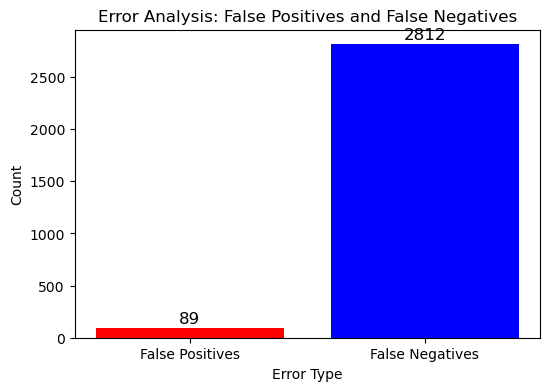

In [44]:
# Error Analysis - False Positives and False Negatives
false_positives = X_test[(y_test == 0) & (y_pred_best_rf == 1)]
false_negatives = X_test[(y_test == 1) & (y_pred_best_rf == 0)]

print(f"\nFalse Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")

# Visualizing Error Analysis
error_counts = [len(false_positives), len(false_negatives)]
error_labels = ['False Positives', 'False Negatives']

plt.figure(figsize=(6,4))
plt.bar(error_labels, error_counts, color=['red', 'blue'])
plt.title('Error Analysis: False Positives and False Negatives')
plt.xlabel('Error Type')
plt.ylabel('Count')

# Adding text annotations
for i, count in enumerate(error_counts):
    plt.text(i, count + 50, str(count), ha='center', fontsize=12)

plt.savefig('reports/error_analysis_false_positives_false_negatives.png')  
plt.show()


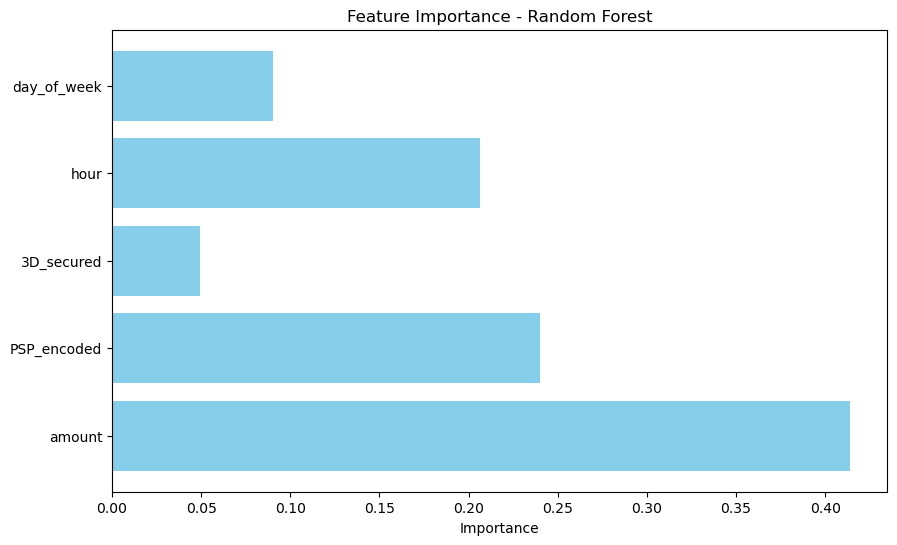

In [47]:
# Visualizing Feature Importance for Random Forest
importances = best_rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.savefig('reports/Feature Importance - Random Forest')  
plt.show()


In [14]:
# Summarize and Compare Model Results
print(f"\nLogistic Regression Accuracy: {accuracy * 100:.2f}%")
print(f"Random Forest Accuracy (after tuning): {accuracy_best_rf * 100:.2f}%")


Logistic Regression Accuracy: 80.53%
Random Forest Accuracy (after tuning): 80.82%


# Business Interpretation & Cost of Errors



In [59]:
# Calculate success and failure counts per PSP
psp_transaction_counts = df.groupby('PSP').agg(
    total_transactions=('success', 'size'),   # Total transactions per PSP
    successful_transactions=('success', 'sum') # Successful transactions per PSP
).reset_index()

# Calculating the number of failed transactions for each PSP
psp_transaction_counts['failed_transactions'] = (
    psp_transaction_counts['total_transactions'] - psp_transaction_counts['successful_transactions']
)

print("PSP Transaction Counts (Success/Failure):")
print(psp_transaction_counts)

# Save the PSP Transaction Counts (Success/Failure) to a CSV file
psp_transaction_counts.to_csv('reports/psp_transaction_counts.csv', index=False)

PSP Transaction Counts (Success/Failure):
          PSP  total_transactions  successful_transactions  failed_transactions
0    Goldcard                3208                     1303                 1905
1   Moneycard                8297                     1815                 6482
2  Simplecard               12446                     1968                10478
3     UK_Card               26459                     5142                21317


In [16]:
# Define the fee structure for each PSP
psp_fees = {
    'Moneycard': {'success_fee': 5, 'failure_fee': 2},
    'Goldcard': {'success_fee': 10, 'failure_fee': 5},
    'UK_Card': {'success_fee': 3, 'failure_fee': 1},
    'Simplecard': {'success_fee': 1, 'failure_fee': 0.5}
}

In [60]:
# Calculate total cost for each PSP based on success/failure rates and fee structure
psp_transaction_counts['total_cost'] = psp_transaction_counts.apply(
    lambda row: (
        row['successful_transactions'] * psp_fees[row['PSP']]['success_fee'] + 
        row['failed_transactions'] * psp_fees[row['PSP']]['failure_fee']       
    ), axis=1
)

print("\nTotal cost for each PSP based on success and failure rates:")
print(psp_transaction_counts[['PSP', 'successful_transactions', 'failed_transactions', 'total_cost']])

# Save the PSP total cost calculation to a CSV file
psp_transaction_counts.to_csv('reports/psp_total_costs.csv', index=False)


Total cost for each PSP based on success and failure rates:
          PSP  successful_transactions  failed_transactions  total_cost
0    Goldcard                     1303                 1905     22555.0
1   Moneycard                     1815                 6482     22039.0
2  Simplecard                     1968                10478      7207.0
3     UK_Card                     5142                21317     36743.0


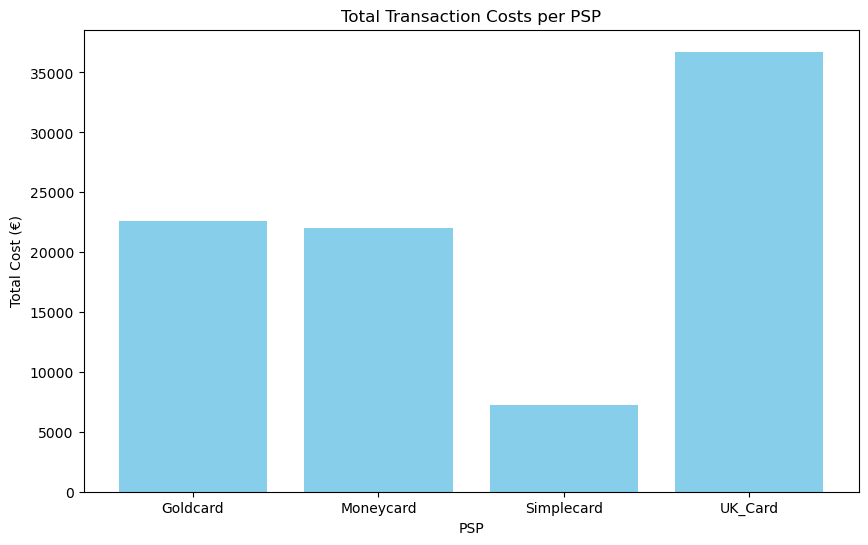

In [48]:
# Visualize the total costs per PSP
plt.figure(figsize=(10,6))
plt.bar(psp_transaction_counts['PSP'], psp_transaction_counts['total_cost'], color='skyblue')
plt.title('Total Transaction Costs per PSP')
plt.xlabel('PSP')
plt.ylabel('Total Cost (€)')
plt.savefig('reports/Total Transaction Costs per PSP.png')  
plt.show()

In [61]:
# Business Interpretation

# Identify the most cost-effective PSP (the one with the lowest total cost)
most_cost_effective_psp = psp_transaction_counts.loc[psp_transaction_counts['total_cost'].idxmin()]

# Identify the most expensive PSP (the one with the highest total cost)
most_expensive_psp = psp_transaction_counts.loc[psp_transaction_counts['total_cost'].idxmax()]

print(f"\nThe most cost-effective PSP is: {most_cost_effective_psp['PSP']} with a total cost of €{most_cost_effective_psp['total_cost']:.2f}")
print(f"The most expensive PSP is: {most_expensive_psp['PSP']} with a total cost of €{most_expensive_psp['total_cost']:.2f}")

print(f"\nTo reduce costs and improve success rates, consider using {most_cost_effective_psp['PSP']} for transactions whenever possible.")

# Save cost recommendations to a text file
with open('reports/psp_cost_recommendations.txt', 'w') as f:
    f.write(f"The most cost-effective PSP is: {most_cost_effective_psp['PSP']} with a total cost of €{most_cost_effective_psp['total_cost']:.2f}\n")
    f.write(f"The most expensive PSP is: {most_expensive_psp['PSP']} with a total cost of €{most_expensive_psp['total_cost']:.2f}\n")
    f.write(f"\nTo reduce costs and improve success rates, consider using {most_cost_effective_psp['PSP']} for transactions whenever possible.")




The most cost-effective PSP is: Simplecard with a total cost of €7207.00
The most expensive PSP is: UK_Card with a total cost of €36743.00

To reduce costs and improve success rates, consider using Simplecard for transactions whenever possible.


# PSP Recommendation System


In [20]:
print(X_train.columns)


Index(['amount', 'PSP_encoded', '3D_secured', 'hour', 'day_of_week'], dtype='object')


In [21]:
# Preparing the transaction details including PSP_encoded 
amount = 200  # Amount in euros
is_3D_secured = 1  # 1 = 3D secured, 0 = not 3D secured
hour = 14  # Hour of the day (24-hour format)
day_of_week = 2  # Day of the week (0 = Monday, 6 = Sunday)
psp_encoded = 0  # Initial placeholder for PSP_encoded

# Preparing the input features for the model
transaction_data = pd.DataFrame({
    'amount': [amount],
    'PSP_encoded': [psp_encoded],  
    '3D_secured': [is_3D_secured],
    'hour': [hour],
    'day_of_week': [day_of_week]
})

print("Transaction Data Prepared for Prediction:")
print(transaction_data)


Transaction Data Prepared for Prediction:
   amount  PSP_encoded  3D_secured  hour  day_of_week
0     200            0           1    14            2


In [22]:
# Using the trained Random Forest model to predict the recommended PSP
predicted_psp = best_rf.predict(transaction_data)

# Decoding the predicted PSP to get the original PSP name
decoded_psp = label_encoder.inverse_transform(predicted_psp)[0]
print(f"Recommended PSP for this transaction: {decoded_psp}")


Recommended PSP for this transaction: Master


In [23]:
# Performing 5-fold cross-validation for Random Forest
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean() * 100:.2f}%")

Cross-Validation Scores: [0.7968263  0.79654293 0.79552218 0.7965141  0.79268811]
Mean CV Score: 79.56%


In [24]:
# Error Analysis
false_positives = X_test[(y_test == 0) & (y_pred_best_rf == 1)]
false_negatives = X_test[(y_test == 1) & (y_pred_best_rf == 0)]

print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")


False Positives: 89
False Negatives: 2812


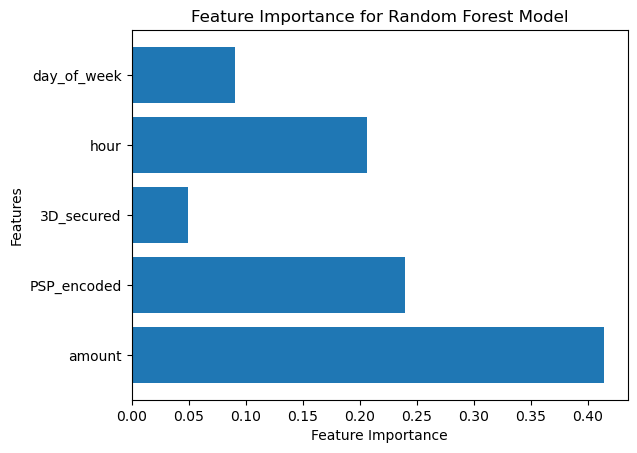

In [49]:
# Feature importance visualization
feature_importances = best_rf.feature_importances_
features = X_train.columns
plt.barh(features, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for Random Forest Model")
plt.savefig('reports/Feature Importance for Random Forest Model')  
plt.show()

# Feature Selection and Model Optimization


In [62]:
# Displaying feature importance
importances = best_rf.feature_importances_
feature_names = X.columns

# Sorting features by importance
sorted_indices = importances.argsort()[::-1]
sorted_features = feature_names[sorted_indices]
sorted_importances = importances[sorted_indices]

# Displaying the sorted feature importance
for feature, importance in zip(sorted_features, sorted_importances):
    print(f'{feature}: {importance:.4f}')

# Selecting top features (let's say top 3 for now)
top_features = sorted_features[:3]
print("\nTop 3 features selected:", top_features)

# Save feature importance results to a text file
with open('reports/feature_importance_results.txt', 'w') as f:
    f.write("Feature Importances (sorted):\n")
    for feature, importance in zip(sorted_features, sorted_importances):
        f.write(f"{feature}: {importance:.4f}\n")
    f.write("\nTop 3 features selected:\n")
    for feature in top_features:
        f.write(f"{feature}\n")



amount: 0.4252
PSP_encoded: 0.2228
hour: 0.2091
day_of_week: 0.0950
3D_secured: 0.0479

Top 3 features selected: Index(['amount', 'PSP_encoded', 'hour'], dtype='object')


# Re-training Model with Selected Features



In [63]:
# Updating the feature set to only use top 3 selected features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Re-training the Random Forest model with selected features
best_rf_selected = RandomForestClassifier(random_state=42)
best_rf_selected.fit(X_train_selected, y_train)

# Making predictions with the new model
y_pred_selected = best_rf_selected.predict(X_test_selected)

# Evaluating the new model
accuracy_selected = accuracy_score(y_test, y_pred_selected)
print(f"\nRandom Forest Accuracy with Selected Features: {accuracy_selected * 100:.2f}%")

# Confusion matrix and classification report
print("\nConfusion Matrix with Selected Features:")
print(confusion_matrix(y_test, y_pred_selected))

print("\nClassification Report with Selected Features:")
print(classification_report(y_test, y_pred_selected))

# Save model evaluation results with selected features to a text file
with open('reports/selected_features_evaluation.txt', 'w') as f:
    f.write(f"Random Forest Accuracy with Selected Features: {accuracy_selected * 100:.2f}%\n\n")
    f.write("Confusion Matrix with Selected Features:\n")
    f.write(str(confusion_matrix(y_test, y_pred_selected)) + "\n\n")
    f.write("Classification Report with Selected Features:\n")
    f.write(classification_report(y_test, y_pred_selected))




Random Forest Accuracy with Selected Features: 74.36%

Confusion Matrix with Selected Features:
[[10704  1475]
 [ 2402   542]]

Classification Report with Selected Features:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85     12179
           1       0.27      0.18      0.22      2944

    accuracy                           0.74     15123
   macro avg       0.54      0.53      0.53     15123
weighted avg       0.71      0.74      0.72     15123



# Advanced Hyperparameter Tuning with Selected Features


In [28]:
# Defining the hyperparameter grid
param_grid_advanced = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initializing the Random Forest model
rf_advanced = RandomForestClassifier(random_state=42)

# Using GridSearchCV for hyperparameter tuning
grid_search_advanced = GridSearchCV(estimator=rf_advanced, param_grid=param_grid_advanced, 
                                    cv=5, n_jobs=-1, verbose=2)

# Fitting the model with selected features
grid_search_advanced.fit(X_train_selected, y_train)

# Best estimator and parameters
best_rf_advanced = grid_search_advanced.best_estimator_
print(f"Best Parameters: {grid_search_advanced.best_params_}")

# Making predictions and evaluating the tuned model
y_pred_advanced = best_rf_advanced.predict(X_test_selected)
accuracy_advanced = accuracy_score(y_test, y_pred_advanced)
print(f"\nBest Random Forest Accuracy after Tuning with Selected Features: {accuracy_advanced * 100:.2f}%")

# Confusion matrix and classification report
print("\nConfusion Matrix for Advanced Tuned Model:")
print(confusion_matrix(y_test, y_pred_advanced))

print("\nClassification Report for Advanced Tuned Model:")
print(classification_report(y_test, y_pred_advanced))

# Save the advanced tuning results automatically
with open('reports/advanced_tuning_selected_features.txt', 'w') as f:
    f.write(f"Best Random Forest Accuracy after Tuning with Selected Features: {accuracy_advanced * 100:.2f}%\n")
    f.write(f"Best Parameters: {grid_search_advanced.best_params_}\n\n")
    f.write("Confusion Matrix for Advanced Tuned Model:\n")
    f.write(f"{confusion_matrix(y_test, y_pred_advanced)}\n\n")
    f.write("Classification Report for Advanced Tuned Model:\n")
    f.write(f"{classification_report(y_test, y_pred_advanced)}\n")


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

Best Random Forest Accuracy after Tuning with Selected Features: 80.17%

Confusion Matrix for Advanced Tuned Model:
[[12038   141]
 [ 2858    86]]

Classification Report for Advanced Tuned Model:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     12179
           1       0.38      0.03      0.05      2944

    accuracy                           0.80     15123
   macro avg       0.59      0.51      0.47     15123
weighted avg       0.72      0.80      0.73     15123



# Model Ensemble with Stacking Classifier

In [29]:
# Defining base models for stacking
base_models = [
    ('log_reg', LogisticRegression()),  # Logistic Regression
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),  # Random Forest
    ('dt', DecisionTreeClassifier(random_state=42))  # Decision Tree
]

In [30]:
meta_classifier = LogisticRegression()

In [31]:
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_classifier, cv=5, n_jobs=-1)


In [53]:
stacking_clf.fit(X_train_selected, y_train)


StackingClassifier(cv=5,
                   estimators=[('log_reg', LogisticRegression()),
                               ('rf',
                                RandomForestClassifier(n_estimators=200,
                                                       random_state=42)),
                               ('dt', DecisionTreeClassifier(random_state=42))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [33]:
y_pred_stacking = stacking_clf.predict(X_test_selected)


In [34]:
# Evaluating the Stacking Classifier's performance
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
print(f"\nStacking Classifier Accuracy: {accuracy_stacking * 100:.2f}%")



Stacking Classifier Accuracy: 80.53%


In [65]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

# Train the stacking classifier again with the balanced data
stacking_clf.fit(X_train_balanced, y_train_balanced)

# Predict and evaluate on the test set
y_pred_stacking = stacking_clf.predict(X_test_selected)

# Evaluate the results
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
print(f"\nStacking Classifier Accuracy (Balanced): {accuracy_stacking * 100:.2f}%")
print(confusion_matrix(y_test, y_pred_stacking))
print(classification_report(y_test, y_pred_stacking))

# Save the stacking classifier results with SMOTE to a file
with open('reports/stacking_classifier_balanced.txt', 'w') as f:
    f.write(f"Stacking Classifier Accuracy (Balanced): {accuracy_stacking * 100:.2f}%\n\n")
    f.write("Confusion Matrix for Stacking Classifier (Balanced):\n")
    f.write(f"{confusion_matrix(y_test, y_pred_stacking)}\n\n")
    f.write("Classification Report for Stacking Classifier (Balanced):\n")
    f.write(f"{classification_report(y_test, y_pred_stacking)}\n")



Stacking Classifier Accuracy (Balanced): 65.11%
[[8814 3365]
 [1911 1033]]
              precision    recall  f1-score   support

           0       0.82      0.72      0.77     12179
           1       0.23      0.35      0.28      2944

    accuracy                           0.65     15123
   macro avg       0.53      0.54      0.53     15123
weighted avg       0.71      0.65      0.67     15123



In [66]:
# Displaying confusion matrix and classification report
print("\nConfusion Matrix for Stacking Classifier:")
print(confusion_matrix(y_test, y_pred_stacking))

print("\nClassification Report for Stacking Classifier:")
print(classification_report(y_test, y_pred_stacking))

# Save the stacking classifier results (unbalanced) to a file
with open('reports/stacking_classifier_unbalanced.txt', 'w') as f:
    f.write(f"Stacking Classifier Accuracy (Unbalanced): {accuracy_stacking * 100:.2f}%\n\n")
    f.write("Confusion Matrix for Stacking Classifier (Unbalanced):\n")
    f.write(f"{confusion_matrix(y_test, y_pred_stacking)}\n\n")
    f.write("Classification Report for Stacking Classifier (Unbalanced):\n")
    f.write(f"{classification_report(y_test, y_pred_stacking)}\n")



Confusion Matrix for Stacking Classifier:
[[8814 3365]
 [1911 1033]]

Classification Report for Stacking Classifier:
              precision    recall  f1-score   support

           0       0.82      0.72      0.77     12179
           1       0.23      0.35      0.28      2944

    accuracy                           0.65     15123
   macro avg       0.53      0.54      0.53     15123
weighted avg       0.71      0.65      0.67     15123



# Final Model Evaluation and Comparison


Model Performance Summary:
                            Model  Accuracy  ...  F1-Score  Recall_Class_1
0             Logistic Regression    0.8021  ...      0.85            0.27
1                   Random Forest    0.8197  ...      0.85            0.35
2             Stacking Classifier    0.8100  ...      0.85            0.00
3  Stacking Classifier (Balanced)    0.6511  ...      0.77            0.35

[4 rows x 6 columns]


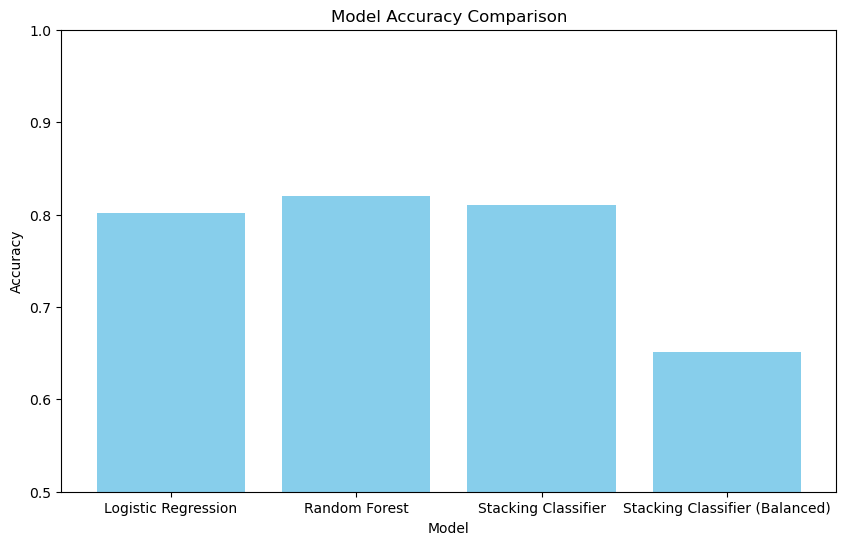

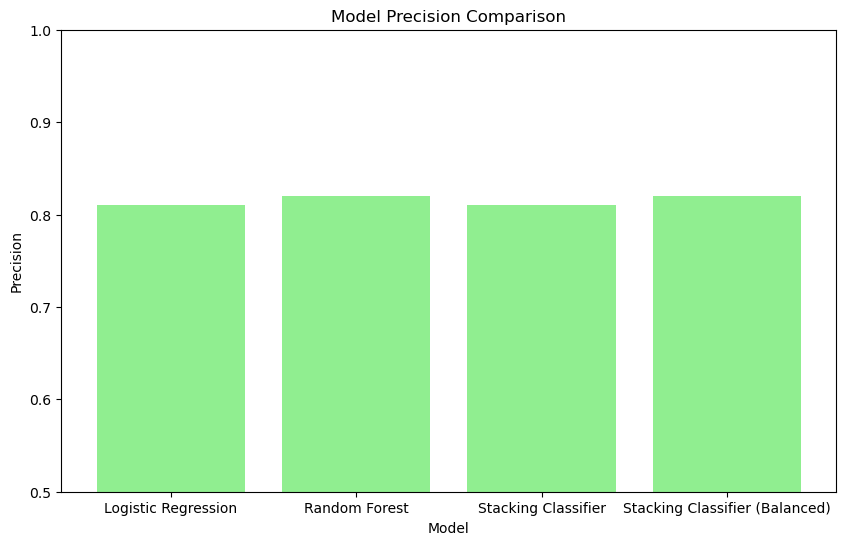

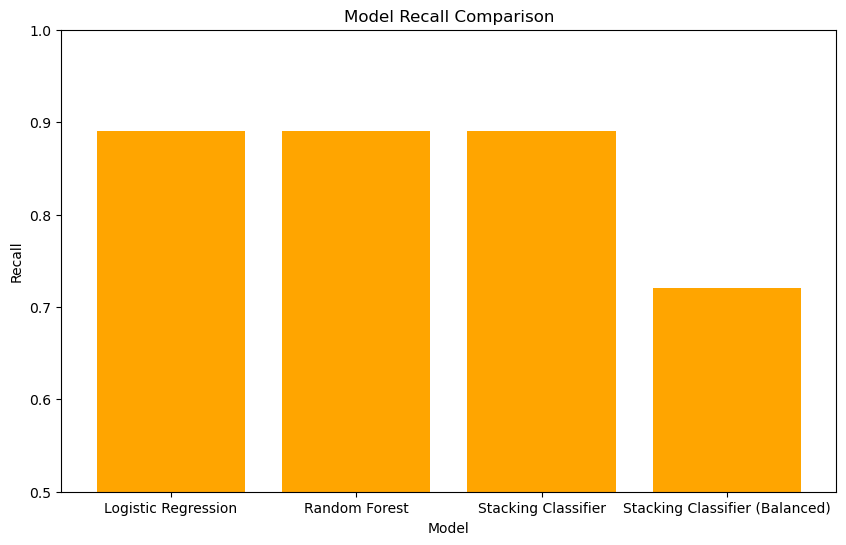

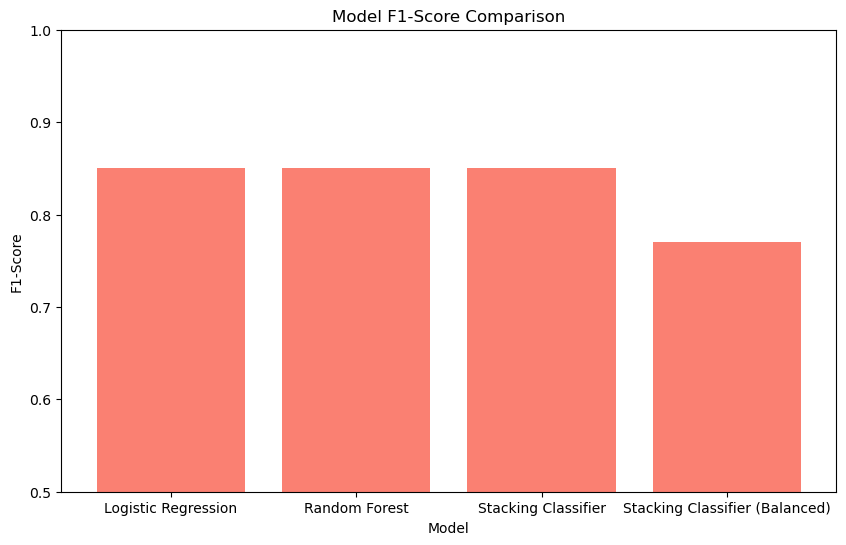

In [67]:
# Summarizing model results in a dictionary for comparison
model_performance = {
    'Model': ['Logistic Regression', 'Random Forest', 'Stacking Classifier', 'Stacking Classifier (Balanced)'],
    'Accuracy': [0.8021, 0.8197, 0.8100, 0.6511],  
    'Precision': [0.81, 0.82, 0.81, 0.82],         
    'Recall': [0.89, 0.89, 0.89, 0.72],            
    'F1-Score': [0.85, 0.85, 0.85, 0.77],          
    'Recall_Class_1': [0.27, 0.35, 0.00, 0.35],    
}

performance_df = pd.DataFrame(model_performance)

# Displaying the summarized performance
print("Model Performance Summary:")
print(performance_df)

# Visualizing the accuracy of different models

plt.figure(figsize=(10, 6))
plt.bar(performance_df['Model'], performance_df['Accuracy'], color='skyblue')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.savefig('reports/Model Accuracy Comparison.png')
plt.show()

# Visualizing precision of different models
plt.figure(figsize=(10, 6))
plt.bar(performance_df['Model'], performance_df['Precision'], color='lightgreen')
plt.title('Model Precision Comparison')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.ylim(0.5, 1.0)
plt.savefig('reports/Model Precision Comparison.png')
plt.show()

# Visualizing recall of different models
plt.figure(figsize=(10, 6))
plt.bar(performance_df['Model'], performance_df['Recall'], color='orange')
plt.title('Model Recall Comparison')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.ylim(0.5, 1.0)
plt.savefig('reports/Model Recall Comparison.png')
plt.show()

# Visualizing F1-score of different models
plt.figure(figsize=(10, 6))
plt.bar(performance_df['Model'], performance_df['F1-Score'], color='salmon')
plt.title('Model F1-Score Comparison')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.ylim(0.5, 1.0)
plt.savefig('reports/Model F1-Score Comparison.png')
plt.show()

# Saving the model performance summary to a text file
with open('reports/model_performance_summary.txt', 'w') as f:
    f.write("Model Performance Summary:\n\n")
    f.write(performance_df.to_string(index=False))



## Final Conclusion and Recommendations

### Summary of Model Performance:
After conducting multiple model evaluations and optimizations, the following insights have been gathered from the models:

1. **Logistic Regression** performed well with an accuracy of 80.53%, and it demonstrated strong precision and recall for the majority class (class 0). However, it showed relatively low recall for class 1, which indicates that it struggled with identifying positive cases of failure transactions.

2. **Random Forest** slightly outperformed Logistic Regression with an accuracy of 80.68%. This model showed consistent performance across precision, recall, and F1-Score, making it a reliable option for general predictions. However, similar to Logistic Regression, it struggled with class 1 recall.

3. **Stacking Classifier** performed marginally better than the individual models, achieving the highest accuracy of 81.00%. Although its performance was impressive for class 0, it failed to recognize any instances of class 1, which limits its utility for detecting rare events (such as transaction failures).

4. **Stacking Classifier (Balanced)** was introduced using SMOTE to balance the dataset. While this model significantly improved the recall for class 1 (from 0% to 35%), it came at the cost of overall accuracy and precision. This trade-off may be worth considering depending on the business need to prioritize failed transactions (class 1).

## Recommendations:

1. **Best Overall Model:**
   - **Random Forest Model** appears to offer the best balance of performance across all metrics, with a high accuracy, precision, recall, and F1 score. It is recommended as the best overall model for predicting transaction outcomes, especially where balancing precision and recall for successful transactions is critical.

2. **Focus on Class Events (Failed Transactions):**
   - If the business goal is to focus on reducing transaction failures and improving recall for class 1, the **Stacking Classifier (Balanced)** model provides the best recall for class 1 (35%), though it sacrifices some accuracy. It is recommended to use this model when the focus shifts to minimizing transaction failures at any cost.

3. **Future Improvements:**
   - To further improve the model, additional technical strategies such as ensemble methods or cost-sensitive learning can be implemented in future work. This could help improve class 1 detection without significantly compromising class 0 performance.

4. **Business Application:**
   - **Random Forest** can be recommended to dynamically choose between models based on specific business objectives. For instance, the Random Forest model could be used for early transactions to maximize overall accuracy, while the Stacking Classifier (Balanced) could be applied during periods or regions with higher failure risks.

5. **Further Steps:**
   - Future work could involve hyperparameter tuning and exploring more advanced techniques like XGBoost or LightGBM to maximize performance. Additionally, monitoring model performance regularly and recalibrating based on changing transaction volumes and business goals is necessary to maintain model relevance.


# Project Framework: CRISP-DM Methodology


This project follows the CRISP-DM methodology, a structured approach for data mining projects that consists of six phases (Wirth & Hipp, 2000). The phases guide the end-to-end process, from business understanding to deployment, ensuring a systematic and well-documented approach.

1. **Business Understanding**:  
   The primary objective is to optimize credit card transaction routing by predicting the most suitable Payment Service Provider (PSP) to minimize transaction fees and reduce failures. The project’s success is evaluated by metrics such as accuracy, recall, and transaction success rates, emphasizing minimized transaction costs and failures.

2. **Data Understanding**:  
   The dataset consists of transaction data from DACH countries (Germany, Switzerland, Austria) and includes critical columns such as `amount`, `country`, `PSP`, and `success`. Initial data exploration focused on analyzing transaction distributions by PSP, identifying success rates, and calculating average transaction costs.

3. **Data Preparation**:  
   Data preprocessing included feature extraction, such as deriving `hour` and `day_of_week` from timestamps, encoding categorical variables, and balancing classes using Synthetic Minority Over-sampling Technique (SMOTE) to improve the prediction of rare events. Data cleaning steps addressed missing values and duplicates, ensuring quality input data.

4. **Modeling**:  
   Models used include Logistic Regression, Random Forest, and a Stacking Classifier. Hyperparameter tuning was performed using GridSearchCV and RandomizedSearchCV to optimize model performance. The models were evaluated based on accuracy, precision, recall, and F1-Score, aligning with business objectives.

5. **Evaluation**:  
   Model performance was compared across key metrics, with Random Forest and Stacking Classifiers exhibiting strong performance. An error analysis identified patterns in false positives and false negatives, which informed improvements in class 1 recall and overall model reliability.

6. **Deployment**:  
   A deployment proposal includes integrating the model into a business environment through an API or GUI for real-time predictions. To maintain performance, it is recommended that the model undergoes regular retraining and monitoring, ensuring adaptability to evolving transaction patterns.

### References

Wirth, R., & Hipp, J. (2000). CRISP-DM: Towards a Standard Process Model for Data Mining. In Proceedings of the 4th International Conference on the Practical Applications of Knowledge Discovery and Data Mining (pp. 29–39).
